### Word generator
Network are learned to predict next letter of a word from a list of 20k words.
After that it creates its own word by passing output letter to input.

Here we set up plot inlining options and its size:

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 12)
from IPython import display

Import modules:

In [2]:
import pynn as nn
import pynnui as nnui
import math
from math import floor
from random import random, shuffle
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import signal

Load data:

In [3]:
data = open('data/20k.txt').read()
words = []
for word in data.split('\n'):
    words.append(word + '\n')
    
maxlen = max([len(w) for w in words])

Char to index and back conversion:

In [4]:
chars = sorted(list(set(data)))
ci = {c:i for i,c in enumerate(chars)}
ic = {i:c for i,c in enumerate(chars)}

size = len(chars)

print(chars)

['\n', "'", '-', '.', '0', '1', '2', '4', '5', '9', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


To learn our network we use [BPTT](https://en.wikipedia.org/wiki/Backpropagation_through_time) with [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) plus [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad). [Softmax](https://en.wikipedia.org/wiki/Softmax_function) loss is used.

In [5]:
class Entry:
    def __init__(self, ichar, ochar):
        self.ichar = ichar
        self.ochar = ochar

    def getinput(self, buf):
        nn.array.clear(buf)
        buf.np[self.ichar] = 1.

    def getouptut(self, buf):
        nn.array.clear(buf)
        buf.np[self.ochar] = 1.


class Word:
    def __init__(self, word):
        self.word = word

    def __getitem__(self, i):
        return Entry(ci[self.word[i]], ci[self.word[i + 1]])

    def __len__(self):
        return len(self.word) - 1


def BGen(data, bsize):
    diter = iter(data)
    while True:
        batch = []
        try:
            for _ in range(bsize):
                batch.append(Word(next(diter)))
        except StopIteration:
            pass
        if len(batch) == 0:
            break
        yield batch


def EGen(data):
    while True:
        yield BGen(data, 20)
        shuffle(data)

Hyperparameters:

In [6]:
shid = 200
batch_size = 20
rate = 1e-1
clip = 5e0

Define network structure:

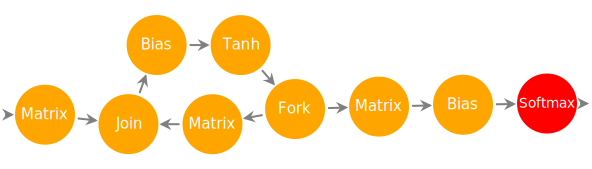

In [7]:
net = nn.Network(size, size)

net.addnodes([
    nn.Matrix(size, shid),
    nn.Matrix(shid, shid),
    nn.Join(shid),
    nn.Bias(shid),
    nn.Tanh(shid),
    nn.Fork(shid),
    nn.Matrix(shid, size),
    nn.Bias(size),
    nn.SoftmaxLoss(size)
])

net.connect([
    nn.Path(0, (2, 0)),
    nn.Path(1, (2, 1)),
    nn.Path(2, 3),
    nn.Path(3, 4),
    nn.Path(4, 5),
    nn.Path((5, 1), 1, mem=True),
    nn.Path((5, 0), 6),
    nn.Path(6, 7),
    nn.Path(7, 8)
])

net.setinputs(0)
net.setoutputs(8)

display.SVG(data=nnui.Graph(net).svg())

Initialize counters:

In [8]:
class Plotter:
    def __init__(self, bsize, esize, freq, iloss=0.):
        self.bsize = bsize
        self.batch = 0
        self.esize = esize
        self.epoch = 0
        self.freq = freq
        
        self.sloss = iloss
        self.losses = []
        self.epochs = []
        
    def _epoch(self, loss):
        self.epoch += 1
        self.batch = 0
        
    def _batch(self, loss):
        self.sloss = 0.99*self.sloss + 0.01*loss
        self.batch += 1
        if ((self.batch + 1) % self.freq) == 0:
            sepoch = self.epoch + min(1.0, self.batch/self.esize)
            self.epochs.append(sepoch)
            self.losses.append(self.sloss)

            fig = plt.figure()
            ax = (fig.add_subplot(211), fig.add_subplot(212))
            ax[0].plot(self.epochs, self.losses)
            r = max(len(self.losses) - 100, 0)
            ax[1].plot(self.epochs[r:], self.losses[r:])
            ax[1].text(sepoch, self.sloss, str(self.sloss))

            display.clear_output(wait=True)

            plt.show()
        
plotter = Plotter(batch_size, (len(words) - 1)//batch_size + 1, 20)

In [9]:
class Watchdog:
    class BMon:
        def __init__(self, outer):
            self.outer = outer
            
        def __call__(self, ctx):
            self.outer._bmon(ctx)
            
    class EMon:
        def __init__(self, outer):
            self.outer = outer
            
        def __call__(self, ctx):
            self.outer._emon(ctx)

    def __init__(self, plotter):
        self.bmon = self.BMon(self)
        self.emon = self.EMon(self)
        self.stop = False
        self.plotter = plotter

    def _bmon(self, teacher):
        self.plotter._batch(teacher.ctx.loss)
        if self.stop:
            self.stop = False
            raise StopIteration
            
    def _emon(self, teacher):
        self.plotter._epoch(teacher.ctx.loss)
            
    def _stop(self):
        self.stop = True
            
watchdog = Watchdog(plotter)

In [10]:
factory = nn.array.newFactory()

teacher = nn.Teacher(
    factory, EGen(words), net,
    adagrad=True, rate=rate, clip=clip, maxlen=maxlen, 
    bmon=watchdog.bmon, emon=watchdog.emon
)

Main learning loop. You can interrupt it and continue whenever you want.

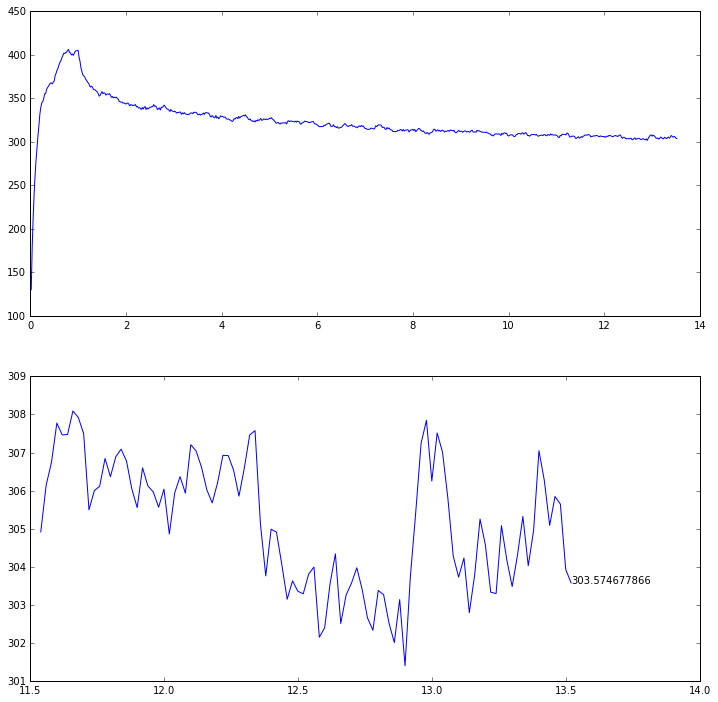

In [11]:
signal.signal(signal.SIGINT, lambda s, f: watchdog._stop())
ctx = teacher.teach()

Here network generates word for each alphabet letter.

In [12]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
feeder = nn.Feeder(factory, net, ctx.state)

for ch in alphabet:

    a = ci[ch]
    print(ch, end='')
    feed = feeder.feed()

    for i in range(0x40):
        Entry(a, 0).getinput(feeder.src)
        next(feed)
        a = np.random.choice(range(size), p=feeder.dst.get())
        ch = ic[a]

        if ch == '\n':
            break
        print(ch, end='')
    print()

adersoaus
bunahl
concicteres
defauve
evartish
forbssiou
genduale
hend
infanhsuytiabel
jelting
kintent
lai
molas
noptial
ostiast
pelow
qrares
reshle
souver
tentisp
unrativion
vistes
wure
xl
yw
zoleven
